# License Plate Detection and Character Recognition: Tutorial

This is a two stage lightweight and robust license plate recognition in SSD and LPRNet using Tensorflow. SSD is a very well-known real-time single-step object detector model and It is trained for license plate detection. LPRNet, another real-time end-to-end DNN, is utilized for the subsquent recognition. This network is attributed by its superior performance with low computational cost without preliminary character segmentation.
Here is the illustration of the proposed pipeline:

![image](./images/2_step_lpr_flow.PNG)

### Performances on GAP8


|                       | Algorithm |   Dataset    | Input size | # Parameters | MAC operations | Inference Time @ 175MHz |   Accuracy    |
| :-------------------: | :-------: | :----------: | :--------: | :----------: | :------------: | :---------------------: | :-----------: |
|  **1. LP Detection**  |    SSD    | OpenImagesV4 | 320x240 px |    3.1 M     |     515 M      |    0.557s (1.73 FPS)    |   mAP 38.9%   |
| **2. LP Recognition** |  LPRNet   | CCPD, Czech  |  94x24 px  |    1.0 M     |     172 M      |    0.343s (1.62 FPS)    | LP-RR >99.13% |


|                             |  Algorithm   | # Parameters | MACs  | Inference Time @ 175MHz | Av. Power | Energy-per-inference |
| :-------------------------: | :----------: | :----------: | :---: | :---------------------: | :-------: | :------------------: |
| **Detection + Recognition** | SSD + LPRNet |    4.1 M     | 687 M |    0.92s (1.09 FPS)     |  117 mW   |        108mJ         |


# Step 1: License Plate Detection (SSD)

This fisrt step makes use of a general purpose single-step object detector to detect license plates in an image.

**SSD (Single-Shot Detector)** is the algorithm deployed, with a SSDliteV2 architecture (Based on MobilenetV2). 

The whole model has 3.1M parameters and takes `515M MACs` on GAP8 to process.

This step is implemented through the official [Tensorflow API for object detection](https://github.com/tensorflow/models/tree/master/research/object_detection) (please refer to this repo for further information).

The model was trained with the [OpenImagesV4 Dataset](https://storage.googleapis.com/openimages/web/index.html) filtering out just images with license plates with [this Toolkit](https://github.com/EscVM/OIDv4_ToolKit).



### Imports

In [359]:

import os
import pathlib
import sys
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib inline


Select GPU

In [360]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Compile protobufs (just once is sufficient)

In [361]:
# %%bash
# cd external/tensorflow-api/research/
# pwd
# protoc object_detection/protos/*.proto --python_out=.

Add "models" directory of [Tensorflow Object Detection API](https://github.com/tensorflow/models/) to PYTHONPATH to succesfully import its libraries.


In [362]:
current_path=os.getcwd()
tensorflow_path=os.getcwd()+'/external/tensorflow-api/research'
sys.path.append(current_path)
sys.path.append(tensorflow_path)

print(current_path)
print(tensorflow_path)



/home/lamberti/work/opensource/license-plates-ocr
/home/lamberti/work/opensource/license-plates-ocr/external/tensorflow-api/research


Import Tensorflow API's object detection module.

In [363]:
# Tensorflow Object Detection API modules
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# My own functions
from lp_detection.test_license_plate_detector import load_model, get_image_list, perform_inference, prune_output, generate_crops, overlap_images_with_bboxes

Tensorflow version: 1.15.0


### Define prediction threshold 

The prediction score is a value in a `[0.0 , 1.0]` range. Select a proper threshold to filter out weak predictions and have less False Positives.

In [364]:
THRESH = 0.30

### Select Image
Select an image of a license plate to test the algorithm

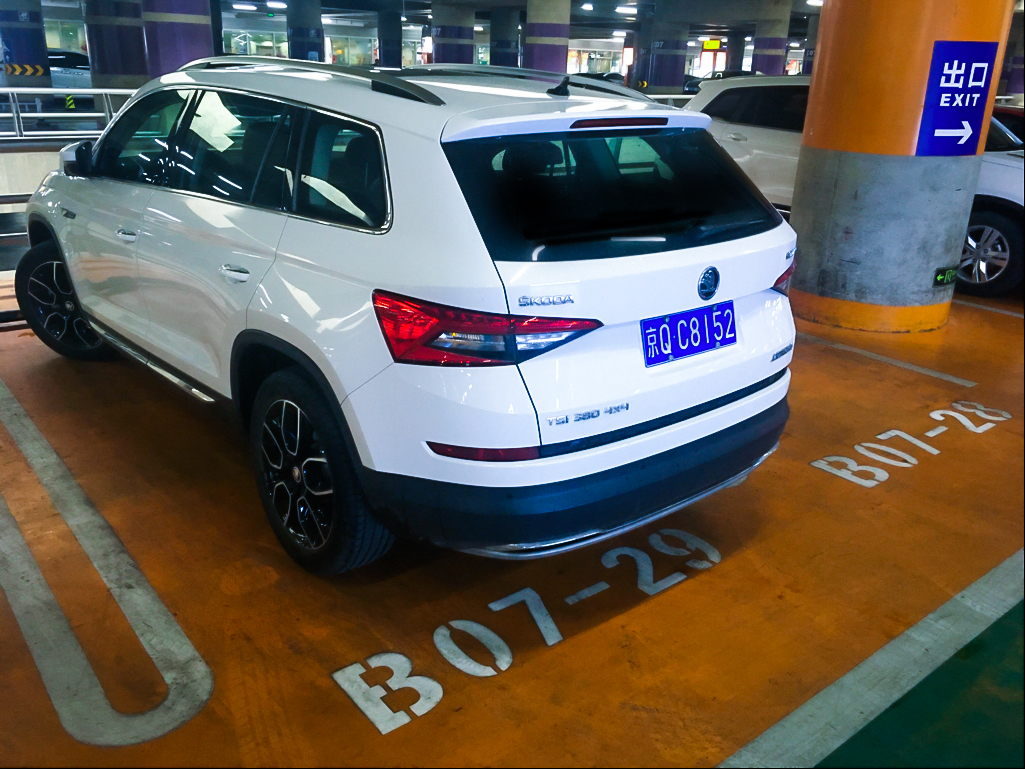

In [365]:

# Image with a license plate taken from a 0 meters distance
# IMAGE_PATH = './dataset/himax_dataset/china/0m_1.jpg' # The image that you want to process

# Image with a license plate taken from a 2 meters distance
# IMAGE_PATH = './dataset/himax_dataset/china/2m_12.jpg' # The image that you want to process

# Random image taken from the web: https://www.skoda-storyboard.com/en/models/deciphering-number-plates-china/
IMAGE_PATH = './dataset/car_sample.jpg' # The image that you want to process
display(Image.open(IMAGE_PATH).convert("RGB"))


Observation: the image was taken at the following link

https://www.skoda-storyboard.com/en/models/deciphering-number-plates-china/


### Load label map

Label maps map indices to category names, so that when our convolution network predicts 1, we know that this corresponds to the "License Plate" class.

In [366]:
PATH_TO_LABEL_MAP = './dataset/oid_v4_label_map_license_plates.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABEL_MAP, use_display_name=True)

### Select and load prediction model (frozen_graph.pb)

Load an object detection model. Any model exported using the export_inference_graph.py tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet-SSDliteV2" model here.



In [367]:
model_dir = './lp_detection/pre-trained/output_inference_graph_320x240_ssdlitev2_8bit_sym.pb'
detection_model = load_model(model_dir)


loading model with Tensorflow version 1.XX
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Perform inference on the image and apply threshold `THRESH`

In [368]:
image_path = pathlib.Path(IMAGE_PATH)
# perform inference
all_predictions_dict = perform_inference(detection_model, image_path)
# Clean predictions dictionary and apply threshold on detections
output_dict = prune_output(all_predictions_dict, THRESH)

TF 1.XX is being used. Session opened, wait for evaluation...
Evaluation completed.


### Show predicted bounding box

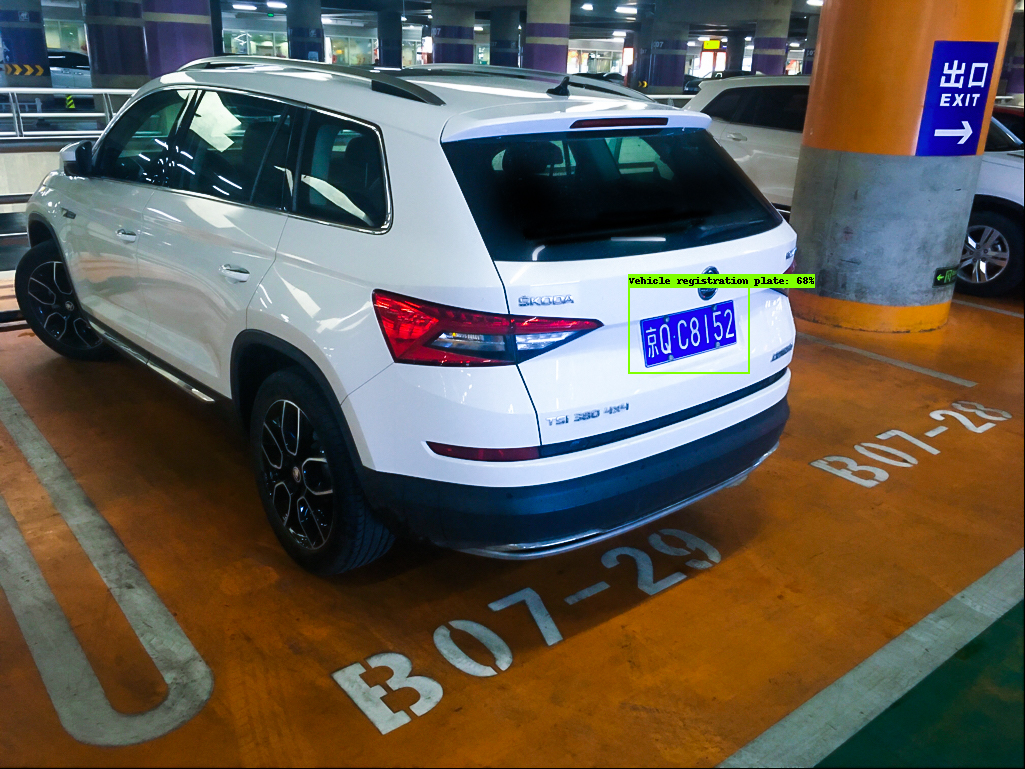

prediction score: 0.681414783000946


In [369]:
# overlap predicted LP boxes to the original image
image_with_detections = overlap_images_with_bboxes(all_predictions_dict, image_path, category_index, thresh=THRESH) # automatically applies threshold

#show predictions
display(Image.fromarray(image_with_detections))
#plt.imshow(image_with_detections, interpolation='nearest')

# Print detection score
for score in output_dict['detection_scores']:
    print('prediction score:', score)

# Step 2: License Plate Character Recognition (LPRNet)

Now let's perform character recognition on the cropped license plate.

**LPRNet** is the algorithm deployed, with its custom lightweight architecture (more info here: [paper](https://arxiv.org/abs/1806.10447)).
This is a segmentation-free method for text recognition that makes just use of a fully convolutional neural network and a decoder to read characters in an image (no RNNs involved!).



The whole model has 1.0M parameters and takes `172M MACs` on GAP8 to process

This step is implemented through the official [Openvino Tensorflow toolkit](https://github.com/opencv/openvino_training_extensions/tree/develop/tensorflow_toolkit/lpr) (please refer to this repo for further information).

To **train** the algorithm only the chatacter annotation (without position) is needed: segmentation-free.


The model was trained on three datasets:

   - [Synthetic Chinese License Plates](https://github.com/opencv/openvino_training_extensions/tree/develop/tensorflow_toolkit/lpr) (270k images)
   - [CCPD: real Chinese License Plates](https://github.com/detectRecog/CCPD) (200k images)
   - [Czech Low-Quality License Plates](https://medusa.fit.vutbr.cz/traffic/research-topics/general-traffic-analysis/holistic-recognition-of-low-quality-license-plates-by-cnn-using-track-annotated-data-iwt4s-avss-2017/) (185k images)



![Dataset images examples](./images/LP_recognition_dataset_examples.png)


## Imports

In [370]:
import os
import pathlib
import sys
import argparse
import random
import numpy as np
import cv2
import glob

Add "lpr" and "utils" directory of [Openvino Tensorflow toolkit](https://github.com/opencv/openvino_training_extensions/tree/develop/tensorflow_toolkit/lpr) to PYTHONPATH to succesfully import its libraries.


In [371]:
LPRNet_path =os.getcwd()+'/external/LPRNet/tensorflow_toolkit/lpr'
LPRNet_path2 =os.getcwd()+'/external/LPRNet/tensorflow_toolkit/utils'
LPRNet_path3 =os.getcwd()+'/external/LPRNet/tensorflow_toolkit/'

sys.path.append(LPRNet_path)
sys.path.append(LPRNet_path2) # solves "tfutils" not found error
sys.path.append(LPRNet_path3)

print(LPRNet_path)
print(LPRNet_path2)
print(LPRNet_path3)

# sys.path.append('/home/lamberti/work/openvino_training_extensions/tensorflow_toolkit/lpr')
# sys.path.append('/home/lamberti/work/openvino_training_extensions/tensorflow_toolkit/utils') # solves "tfutils" not found error
# sys.path.append('/home/lamberti/work/2_steps_license_plates/lp_recognition') # solves "tfutils" not found error


/home/lamberti/work/opensource/license-plates-ocr/external/LPRNet/tensorflow_toolkit/lpr
/home/lamberti/work/opensource/license-plates-ocr/external/LPRNet/tensorflow_toolkit/utils
/home/lamberti/work/opensource/license-plates-ocr/external/LPRNet/tensorflow_toolkit/


Import Openvino's License Plate Recognition module.

In [372]:
import tensorflow as tf
# import tensorflow.contrib.slim as slim
print('Tensorflow version:', tf.__version__)

sys.path.append('./external/tensorflow-api/research/')
sys.path.append('./external/tensorflow-api/research/transformer/')

# import from openvino repository
from lpr.utils import dataset_size
from lpr.trainer import inference, decode_beams
from tfutils.helpers import load_module


Tensorflow version: 1.15.0


Define a couple of useful functions (original ones in lp_recognition/infer_frozen_graph_single_image.py/)

In [373]:
def load_graph(frozen_graph_filename):
  with tf.gfile.GFile(frozen_graph_filename, 'rb') as file:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(file.read())
  with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def)
  return graph

def display_license_plate(number, license_plate_img):
  size = cv2.getTextSize(number, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 2)
  text_width = size[0][0]
  text_height = size[0][1]

  height, width, _ = license_plate_img.shape
  license_plate_img = cv2.copyMakeBorder(license_plate_img, 0, text_height + 10, 0,
                                         0 if text_width < width else text_width - width,
                                         cv2.BORDER_CONSTANT, value=(255, 255, 255))
  cv2.putText(license_plate_img, number, (0, height + text_height + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 0), 2)

  return license_plate_img

## Generate crops from predictions



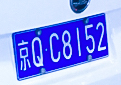

In [374]:
from lp_detection.test_license_plate_detector import generate_crops

lp_crops = generate_crops(output_dict, image_path) 
for crop in lp_crops:
    display(Image.fromarray(crop))
    #plt.imshow(crop, interpolation='nearest')
    


### Select model and configuration file

In [375]:
recognition_model='./lp_recognition/pre-trained/LPRNet_CCPD_no_tile_64_quantized/graph.pb'
config_file = './lp_recognition/config/config_ccpd_64_quantized.py'

### Load graph and configuration file

In [376]:
graph = load_graph(recognition_model)
config = load_module(config_file)

config file loaded successfully


### Prepare image
Apply necessary transorfmations to the image

In [377]:

image = crop
img = cv2.resize(image, (94, 24))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # depends on the image, not always needed
img = np.float32(img)
img = np.multiply(img, 1.0/255.0)

## Read License Plate

In [378]:
input = graph.get_tensor_by_name("import/input:0")
output = graph.get_tensor_by_name("import/d_predictions:0")

with tf.Session(graph=graph) as sess:
    results = sess.run(output, feed_dict={input: [img]})

    

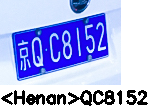

prediction:  <Henan>QC8152


In [379]:
decoded_license_plate = decode_beams(results, config.r_vocab)[0]
image_with_prediction = display_license_plate(decoded_license_plate, image)

#plt.imshow(img_to_display, interpolation='nearest')
display(Image.fromarray(image_with_prediction))

print('prediction: ',decoded_license_plate)

